In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import pods
import pandas as pd
from scipy import stats
SEED=112
np.random.seed(SEED)

# Load Dataset

In [5]:
# oil_data = pods.datasets.banana()

In [7]:
filename = 'data/banana_X_train.txt'
X_train = pd.read_table(filename, sep=',', header=None)
X_tr = X_train.as_matrix()

In [8]:
Y_file = 'data/banana_Y_train.txt'
Y_train = pd.read_table(Y_file, header=None)
Y_tr = Y_train.as_matrix()

In [9]:
def plot_dataset(X, Y, Z=None):
    ind = np.nonzero(Y)
    neg_ind = np.where(Y==0)
    neg_ind = list(neg_ind)
    neg_indices = np.array(neg_ind[0])
    ind = list(ind)
    indices= np.array(ind[0]) 
    plt.plot(X_tr[indices,0], X_tr[indices,1], 'ro')
    plt.plot(X_tr[neg_indices,0], X_tr[neg_indices,1], 'bo')
    if Z is not None:
        plt.plot(Z[:,0], Z[:,1], 'ko')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    
    

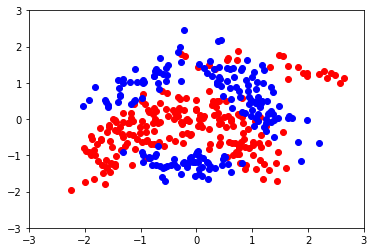

In [10]:
plot_dataset(X_tr, Y_tr)

# Set Kernel and number inducing points and train a full GP classifier

In [18]:
num_inducing=10

In [19]:
kernel= GPy.kern.RBF(input_dim=2, ARD=True, name='b_kern')

In [20]:
m = GPy.models.GPClassification(X_tr, Y_tr, kernel=kernel.copy())

In [21]:
m.optimize()

In [22]:
m['']

gp_classification.b_kern.variance:
Param([ 4.18752489])
gp_classification.b_kern.lengthscale:
Param([ 0.88690258,  0.71926814])

In [23]:
m.log_likelihood()

-119.58005413325489

### Placement of inducing points for SVGPC

In [24]:
# m_epdtc = GPy.models.SparseGPClassification(X_tr, Y, kernel=kernel.copy(), num_inducing=10)

In [25]:
m_var1 = GPy.models.SparseGPClassification(X_tr, Y_tr, kernel=kernel.copy(), num_inducing=10, full_var=True)

hii


In [26]:
ep_var = GPy.inference.latent_function_inference.EP_Var(ep_mode='alternated', parallel_updates=True)

In [27]:
# m_ep_var = GPy.core.SparseGP(X=X_tr, Y=Y.copy(), num_inducing=10, kernel=kernel.copy(),  inference_method=ep_var)

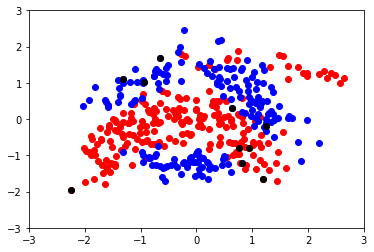

In [28]:
plot_dataset(X_tr, Y_tr, m_var1.inducing_inputs.values)

In [29]:
m_var1.optimize()

### Placement of inducing points using full var_EP.

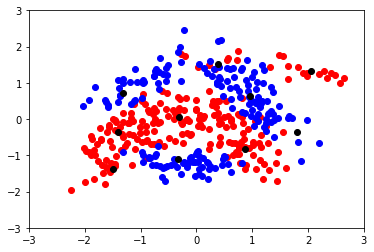

In [30]:
plot_dataset(X_tr, Y_tr, m_var1.inducing_inputs.values)

In [31]:
i = np.random.permutation(X_tr.shape[0])[:num_inducing]
Z = X_tr[i].copy()

lik = GPy.likelihoods.Bernoulli()
from GPy.core import SparseGP
from GPy.inference.latent_function_inference import EPDTC

m_epdtc = GPy.models.SparseGPClassification(X_tr.copy(), Y_tr.copy(), kernel=kernel.copy(), num_inducing=10, full_var=False)

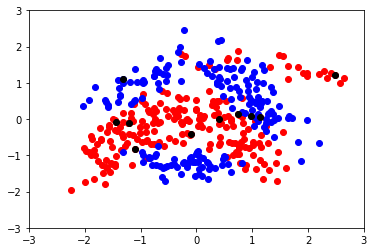

In [32]:
plot_dataset(X_tr, Y_tr, m_epdtc.inducing_inputs.values)


In [33]:
m_epdtc.optimize()

### Placement of inducing points using EPDTC.

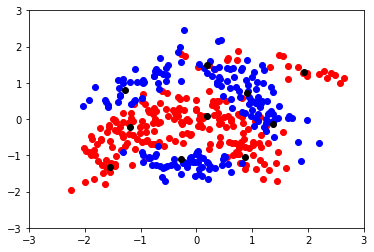

In [34]:
plot_dataset(X_tr, Y_tr, m_epdtc.inducing_inputs.values)


### Placement of inducing points using EP-Var. Noticeable difference

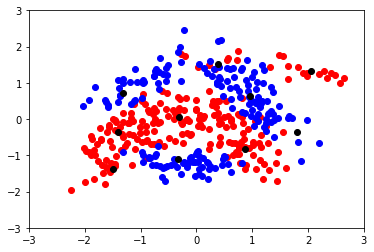

In [35]:
plot_dataset(X_tr, Y_tr, m_var1.inducing_inputs.values)

In [36]:
np.random.seed(SEED)
inds = np.random.permutation(X_tr.shape[0])[:num_inducing]
Z_svgp = X_tr[inds].copy()

lik = GPy.likelihoods.Bernoulli()
m_svgp1 = GPy.core.SVGP(X_tr, Y_tr, Z=Z_svgp, kernel = kernel.copy(), likelihood=lik)


In [37]:
m_svgp1.optimize('lbfgs', max_iters=1400)

### Placement of inducing points for SVGPC (much closer to decision boundaries).

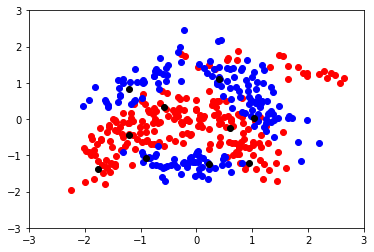

In [38]:
plot_dataset(X_tr, Y_tr, m_svgp1.inducing_inputs.values)

In [39]:
print ("SVGP Banana:", m_svgp1)

('SVGP Banana:', <GPy.core.svgp.SVGP object at 0x7f42305ae950>)


In [40]:
print("SVGP Lengthscales:", m_svgp1['b_kern.lengthscale'])

('SVGP Lengthscales:', SVGP.b_kern.lengthscale:
Param([ 0.71366329,  0.61777839]))


In [41]:
print("EPDTC Banana:", m_epdtc)

('EPDTC Banana:', <GPy.models.sparse_gp_classification.SparseGPClassification object at 0x7f423076ab50>)


In [42]:
print("EPDTC Lengthscales:", m_epdtc['b_kern.lengthscale'])

('EPDTC Lengthscales:', SparseGPClassification.b_kern.lengthscale:
Param([ 0.99429812,  0.82970333]))


In [43]:
print("EPVar1 Banana:", m_var1)

('EPVar1 Banana:', <GPy.models.sparse_gp_classification.SparseGPClassification object at 0x7f4230790990>)


In [44]:
print("EPVar1 Lengthscales:", m_var1['b_kern.lengthscale'])

('EPVar1 Lengthscales:', SparseGPClassification.b_kern.lengthscale:
Param([ 1.03701845,  0.87600427]))


####  Note 

The next part of the code is for automating testset evaluation, we get models from each of these functions: EPDTC, EPVar and SVGPC: We split the data and do a cross fold validation with K = 10 and number of inducing points = 16%. The results are in tune with the ones reported by Hensman et al and other authors 

In [45]:
def get_svgp_model(X_train, Y_train, Z=None, percent=0.15, batchsize=None, ):
    kern_f = GPy.kern.RBF(X_train.shape[1], variance=10.0, lengthscale=1.0, ARD=True, name='f_rbf') 
#     kern_f = GPy.kern.RBF(X_train.shape[1], variance=10.0, lengthscale=(X_train.max(axis=0) - X_train.min(axis=0))/6.0, ARD=True, name='f_rbf') 
    kern_f += GPy.kern.Bias(X_train.shape[1], variance=0.1, name='f_bias')
    kern_f += GPy.kern.White(X_train.shape[1], variance=1e-5, name='f_white')

    lik = GPy.likelihoods.Bernoulli()
    kern_f.name = 'f_kern'
    num_inducing = int(X_train.shape[0]*percent)
    print("percentage of inducing points:", percent)
    Z = np.random.permutation(X_train.copy())[:num_inducing, :]
    m_svgp = GPy.core.SVGP(X=X_train.copy(), Y=Y_train.copy(), Z=Z.copy(), kernel=kern_f.copy(), likelihood=lik.copy(), mean_function=None, Y_metadata=None, name='svgp_crabs')
    return m_svgp  
    

In [46]:
def get_epdtc_model(X_train, Y_train, Z=None, percent=0.15):
    kern_f = GPy.kern.RBF(X_train.shape[1], variance=10.0, lengthscale=1.0, ARD=True, name='f_rbf') 
    kern_f += GPy.kern.Bias(X_train.shape[1], variance=0.1, name='f_bias')
    kern_f += GPy.kern.White(X_train.shape[1], variance=1e-5, name='f_white')
    
    epdtc = GPy.inference.latent_function_inference.EPDTC(ep_mode='alternated',  parallel_updates=True)
    lik = GPy.likelihoods.Bernoulli()
    kern_f.name = 'f_kern'
    num_inducing = int(X_train.shape[0]*percent)
    print("percentage of inducing points:", percent)
    Z = np.random.permutation(X_train.copy())[:num_inducing, :]
#     m_epdtc = GPy.core.SparseGP(X=X_train.copy(), Y=Y_train.copy(), Z=Z.copy(), kernel=kern_f.copy(), likelihood=lik.copy(), inference_method=epdtc, mean_function=None, Y_metadata=None, name='epdtc')
    m_epdtc =  GPy.models.SparseGPClassification(X=X_train.copy(), Y=Y_train.copy(), Z=Z.copy(), kernel=kern_f.copy(), likelihood=lik.copy(), Y_metadata=None, full_var=False)
    return m_epdtc

In [47]:
def get_epvar_model(X_train, Y_train, Z=None, percent=0.15):
    kern_f = GPy.kern.RBF(X_train.shape[1], variance=10.0, lengthscale=1.0, ARD=True, name='f_rbf') 
    kern_f += GPy.kern.Bias(X_train.shape[1], variance=0.1, name='f_bias')
    kern_f += GPy.kern.White(X_train.shape[1], variance=1e-5, name='f_white')
    
#     epdtc = GPy.inference.latent_function_inference.EPDTC(ep_mode='alternated',  parallel_updates=True)
    lik = GPy.likelihoods.Bernoulli()
    kern_f.name = 'f_kern'
    num_inducing = int(X_train.shape[0]*percent)
    print("percentage of inducing points:", percent)
    Z = np.random.permutation(X_train.copy())[:num_inducing, :]
#     m_epdtc = GPy.core.SparseGP(X=X_train.copy(), Y=Y_train.copy(), Z=Z.copy(), kernel=kern_f.copy(), likelihood=lik.copy(), inference_method=epdtc, mean_function=None, Y_metadata=None, name='epdtc')
#     m_epvar =  GPy.models.SparseGPClassification(X=X_train.copy(), Y=Y_train.copy(), Z=Z.copy(), kernel=kern_f.copy(), likelihood=lik.copy(), Y_metadata=None, full_var=True)
    m_epvar = GPy.models.SparseGPClassification(X_train, Y_train, kernel=kernel.copy(), num_inducing=54, full_var=True)
    return m_epvar

In [48]:
import GPy.util.classification

class Dataset():
    def __init__(self, X, Y, Xtest=None, Ytest=None, K=10, seed=42):
        X_orig = X.copy()
        Y_orig = Y.copy()
        np.random.seed(seed=seed)
        if Y.ndim == 1:
            Y = Y.reshape(-1,1)
        
        randomize = np.arange(X.shape[0])
        np.random.shuffle(randomize)
        X = X[randomize,:]
        Y = Y[randomize,:]
        self.K = K
        self.X = X
        self.Y = Y
        self.m_list= []
        self.X_test_list = []
        self.Y_test_list = []
        self.partition_flag = False
        self.model_fn_flag = False
    
    def split_data(self):
        X_train_list = []
        Y_train_list = []
        num_batch = int(self.X.shape[0]/self.K)
        rem = self.X.shape[0] % self.K
        

        for i in range(self.K-1):
            X_batch = self.X[i*num_batch:(i+1)*num_batch,:]  
            Y_batch = self.Y[i*num_batch:(i+1)*num_batch,:]
            X_train_list.append(X_batch)
            Y_train_list.append(Y_batch)
        X_train_list.append(self.X[(self.K-1)*num_batch:self.K*num_batch+rem,:])
        Y_train_list.append(self.Y[(self.K-1)*num_batch:self.K*num_batch+rem,:])
        self.X_train_list = X_train_list
        self.Y_train_list = Y_train_list
        self.partition_flag = True
        
    def show_data_partition(self):
        if self.partition_flag is False:
            self.split_data()
        for i in self.X_train_list:
            print(len(i))
    
    def set_model_function(self, fn, **kwargs):
        self.get_model_fn = fn
        self.fn_args = dict()
        self.fn_kwargs = kwargs
        self.model_fn_flag = True
    
    def get_model_function(self):
        return self.get_model_fn

    def get_model_list(self):
        return self.m_list
    
    def get_test_set(self, i):
        return self.X_test_list[i], self.Y_test_list[i]
    
    def train_KFold(self):
        if self.partition_flag is False:
            self.split_data()
        
        if self.model_fn_flag is False:
            self.set_model_function()
        
        print("value of K: {}".format(self.K)) 
        for i in range(self.K):
            Xtest = self.X_train_list.pop(i)
            Ytest =  self.Y_train_list.pop(i)
            Xtrain_all = np.concatenate(self.X_train_list, axis=0)
            Ytrain_all = np.concatenate(self.Y_train_list, axis=0)
            self.X_train_list.insert(i, Xtest)
            self.Y_train_list.insert(i, Ytest)
            self.X_test_list.append(Xtest)
            self.Y_test_list.append(Ytest)
#             m = get_svgp_model(Xtrain_all, Ytrain_all)
            m = self.get_model_fn(Xtrain_all, Ytrain_all, **self.fn_kwargs)
            m.optimize('lbfgs', max_iters=900)
            self.m_list.append(m)



class EvalClassification():
    def __init__(self, m):
        self.m = m
    
    def NLL(self):
        return self.m.log_likelihood()
    
    def TestNLL1(self, Xtest, Ytest):
        mu = self.m._raw_predict(Xtest)
        predict_mean = self.m.likelihood.gp_link.transf(mu)
        target = Ytest
        probs, probs_var = self.m.predict(Xtest)
        nlprobs = np.log(probs)
        nlprobsvar = np.log(probs_var)
        NLP = np.mean(np.log(probs), axis=0)
#         NLP_Var = np.median(np.log(nlprobsvar), axis=0)
        self.probs = probs
        return probs, NLP
    
    def TestNLL(self, Xtest, Ytest, median=False):
        mu, var = self.m._raw_predict(Xtest)
        nll = -stats.norm.logcdf(1.0 * Ytest * mu / np.sqrt(1 + var))
        if median:
            val= np.median(nll)
        else:
            val= np.mean(nll)
        sigma2 = 2*np.nanstd(nll)
        return val, sigma2
        
    
    def conf_matrix(self, Xtest, Ytest, threshold=0.5):
        assert self.probs.size == Ytest.size
        decision = np.zeros((Ytest.size, 1))
        decision[self.probs>threshold] = 1
        diff = decision - Ytest
        f_0 = diff[diff==-1].size
        f_1 = diff[diff==1].size    
        t_1 = np.sum(decision[diff ==0])
        t_0 = Ytest.size - f_0 - f_1 - t_1
        correct = t_0+t_1
        false = Ytest.size -1
        error = (f_0 + f_1)/ np.float(Ytest.size)
        return error, f_0, f_1, t_0, t_1
        

In [49]:
Y_train = Y_tr.reshape(-1,1)
X_train = X_tr

#### Evaluation of SVGPC model on Training Set(Training Error)

In [57]:

probs, probs_var = m_svgp1.predict(X_train)
decision = np.zeros((Y_train.size, 1))
decision[probs>0.5] = 1
diff = decision - Y_train
f_0 = diff[diff==-1].size
f_1 = diff[diff==1].size 
error = np.sum(f_0+f_1)/ np.float(Y_train.size)
print(error)


0.1175


#### Evaluation of EPDTC model on Training Set(Training Error)

In [58]:
probs, probs_var = m_epdtc.predict(X_train)
decision = np.zeros((Y_train.size, 1))
decision[probs>0.5] = 1
diff = decision - Y_train
f_0 = diff[diff==-1].size
f_1 = diff[diff==1].size 
error = np.sum(f_0+f_1)/ np.float(Y_train.size)
print(error)


0.0925


#### Evaluation of EPVar model on Training Set(Training Error)

In [59]:
probs, probs_var = m_var1.predict(X_train)
decision = np.zeros((Y_train.size, 1))
decision[probs>0.5] = 1
diff = decision - Y_train
f_0 = diff[diff==-1].size
f_1 = diff[diff==1].size 
error = np.sum(f_0+f_1)/ np.float(Y_train.size)
print(error)


0.0875


In [51]:
X_train = X_tr
Y_train = Y_tr

#### Test set evaluation for EPDTC

In [52]:
ds1 = Dataset(X=X_train, Y=Y_train, K=10)
ds1.split_data()
ds1.show_data_partition()
ds1.set_model_function(get_epdtc_model, percent=0.16)
ds1.train_KFold()


40
40
40
40
40
40
40
40
40
40
value of K: 10
('percentage of inducing points:', 0.16)
('percentage of inducing points:', 0.16)
('percentage of inducing points:', 0.16)
('percentage of inducing points:', 0.16)
('percentage of inducing points:', 0.16)
('percentage of inducing points:', 0.16)
('percentage of inducing points:', 0.16)
('percentage of inducing points:', 0.16)
('percentage of inducing points:', 0.16)
('percentage of inducing points:', 0.16)


In [53]:
test_nll_list = []
test_nll_list2 = []
error_list= []
sigma2_list = []

for ind, mi in enumerate(ds1.get_model_list()):
    ec = EvalClassification(mi)
    xtest, ytest = ds1.get_test_set(ind)
    testnll1, sigma2 = ec.TestNLL(xtest, ytest)
    
    probs2, testnll2  = ec.TestNLL1(xtest, ytest)
#     testnll2 = ec.TestNLL1(xtest, ytest)
    error, f_0, f_1, t_0, t_1 = ec.conf_matrix(xtest, ytest)
    test_nll_list.append(testnll1)
    sigma2_list.append(sigma2)
    error_list.append(error)

print("Averaged NLL after 10 fold crossvalidation Median:", np.median(test_nll_list))
print("Averaged NLL after 10 fold crossvalidation Mean:", np.mean(test_nll_list))
# print np.median(sigma2_list)
print("Averaged NLL after 10 fold crossvalidation:", np.mean(error_list))
print("Test NLL for each test set:", test_nll_list)

('Averaged NLL after 10 fold crossvalidation Median:', 0.39806568298111256)
('Averaged NLL after 10 fold crossvalidation Mean:', 0.42983981663089138)
('Averaged NLL after 10 fold crossvalidation:', 0.092499999999999999)
('Test NLL for each test set:', [0.3976427774319552, 0.34596455866202802, 0.66740709041746593, 0.46056720482646119, 0.28227503692501943, 0.39298905535578293, 0.52773585216985663, 0.38679940993974704, 0.43852859205032779, 0.39848858853026992])


#### Test set evaluation for SVGPC

In [49]:
ds2 = Dataset(X=X_train, Y=Y_train, K=10)
ds2.split_data()
ds2.show_data_partition()
ds2.set_model_function(get_svgp_model, percent=0.16)
ds2.train_KFold()

40
40
40
40
40
40
40
40
40
40
value of K: 10
percentage of inducing points: 0.16
percentage of inducing points: 0.16
percentage of inducing points: 0.16
percentage of inducing points: 0.16
percentage of inducing points: 0.16
percentage of inducing points: 0.16
percentage of inducing points: 0.16
percentage of inducing points: 0.16
percentage of inducing points: 0.16
percentage of inducing points: 0.16


In [50]:
test_nll_list = []
test_nll_list2 = []
error_list= []
sigma2_list = []

for ind, mi in enumerate(ds2.get_model_list()):
    ec = EvalClassification(mi)
    xtest, ytest = ds2.get_test_set(ind)
    testnll1, sigma2 = ec.TestNLL(xtest, ytest)
    
    probs2, testnll2  = ec.TestNLL1(xtest, ytest)
#     testnll2 = ec.TestNLL1(xtest, ytest)
    error, f_0, f_1, t_0, t_1 = ec.conf_matrix(xtest, ytest)
    test_nll_list.append(testnll1)
    sigma2_list.append(sigma2)
    error_list.append(error)

print("Averaged NLL after 10 fold crossvalidation Median:", np.median(test_nll_list))
print("Averaged NLL after 10 fold crossvalidation Mean:", np.mean(test_nll_list))
# print np.median(sigma2_list)
print("Averaged NLL after 10 fold crossvalidation:", np.mean(error_list))
print("Test NLL for each test set:", test_nll_list)


Averaged NLL after 10 fold crossvalidation Median: 0.39412170316
Averaged NLL after 10 fold crossvalidation Mean: 0.428738005325
Averaged NLL after 10 fold crossvalidation: 0.085
Test NLL for each test set: [0.39556529788161321, 0.33590025836229975, 0.69923639762843082, 0.45603489538015313, 0.27063910915433559, 0.39080780070178489, 0.53374110090858651, 0.38067827252593195, 0.43209881226357572, 0.39267810843833939]


#### Test set evaluation for EPVar

In [52]:
dsvar = Dataset(X=X_train, Y=Y_train, K=10)
dsvar.split_data()
dsvar.show_data_partition()
dsvar.set_model_function(get_epvar_model, percent=16)
dsvar.train_KFold()

40
40
40
40
40
40
40
40
40
40
value of K: 10
percentage of inducing points: 16
percentage of inducing points: 16
percentage of inducing points: 16
percentage of inducing points: 16
percentage of inducing points: 16
percentage of inducing points: 16
percentage of inducing points: 16
percentage of inducing points: 16
percentage of inducing points: 16
percentage of inducing points: 16


In [53]:

test_nll_list = []
test_nll_list2 = []
error_list= []
sigma2_list = []

for ind, mi in enumerate(dsvar.get_model_list()):
    ec = EvalClassification(mi)
    xtest, ytest = dsvar.get_test_set(ind)
    testnll1, sigma2 = ec.TestNLL(xtest, ytest)
    
    probs2, testnll2  = ec.TestNLL1(xtest, ytest)
#     testnll2 = ec.TestNLL1(xtest, ytest)
    error, f_0, f_1, t_0, t_1 = ec.conf_matrix(xtest, ytest)
    test_nll_list.append(testnll1)
    sigma2_list.append(sigma2)
    error_list.append(error)

print("Averaged NLL after 10 fold crossvalidation Median:", np.median(test_nll_list))
print("Averaged NLL after 10 fold crossvalidation Mean:", np.mean(test_nll_list))
# print np.median(sigma2_list)
print("Averaged NLL after 10 fold crossvalidation:", np.mean(error_list))
print("Test NLL for each test set:", test_nll_list)

Averaged NLL after 10 fold crossvalidation Median: 0.416702621523
Averaged NLL after 10 fold crossvalidation Mean: 0.438312781354
Averaged NLL after 10 fold crossvalidation: 0.0925
Test NLL for each test set: [0.42113922889094219, 0.37228382600220239, 0.60585476362973834, 0.47595438784313349, 0.3173542418524754, 0.40136967443929816, 0.51804711268251502, 0.41226601415592645, 0.44755900601370174, 0.41129955802588614]


In [ ]:
import sklearn.datasets as ds